---
## LPC와 LSF를 이용한 vocoder의 구성
### 작성자 : 전인구

### Vocoder
#### Encoding : 음성신호 x를 Linear prediction coefficient (LPC) & residual 신호로 변환한다.

#### Decoding : residual 신호를 LPC를 이용해서 x를 복원해낸다
####                    (사이에 Gaussian noise를 더하기 때문에 x와 복원된 x는 완전 일치하기 어렵다). 

In [1]:
import numpy as np
import librosa
from librosa import lpc
from numpy.random import normal
from scipy.signal import lfilter, deconvolve

##################################################################

# Vocoder from lab08

##################################################################
class filter:
    def __init__(self,M=14):
        self.M=M
        self.memory=np.zeros(M)
        self.weight=np.zeros(M+1)
        self.weight[0]=1
    def set_weight(self,w):
        self.weight=w        
        
class FIR(filter):
    def __init__(self,M):
        super().__init__(M)
        
    def use(self,x):
        L_out=len(x)
        filtered=np.convolve(
                            np.concatenate([self.memory,x]),
                            self.weight
                            ,"same")
        x_out=filtered[-L_out:]
        self.memory=x[-self.M:]
        return x_out
    
    def imp_response(self,scale=1024):
        imp=np.zeros(scale)
        imp[0]=1
        filtered=np.convolve(imp,self.weight,"same")
        IMP=np.fft.fft(filtered)
        
        return np.abs(IMP[:scale//2+1])
        
class IIR(filter):
    def __init__(self,M):
        super().__init__(M)
    
    def use(self,x):
        L_out=len(x)
        filtered=np.zeros(L_out)
        mem=self.memory
        for idx in range(L_out):
            filtered[idx]=x[idx]*self.weight[0]\
                        -np.sum(mem*(self.weight[1:]))
            if self.M==1:
                mem=filtered[idx]
            else:
                mem[1:]=mem[:-1]
                mem[0]=filtered[idx]
        self.memory=mem
        return filtered
    
    def imp_response(self,scale=1024):
        imp=np.zeros(scale)
        imp[0]=1
        filtered=np.zeros(scale)
        mem=np.zeros(self.M)
        for idx in range(scale):
            filtered[idx]=imp[idx]*self.weight[0]\
                        -np.sum(mem*(self.weight[1:]))
            if self.M==1:
                mem=filtered[idx]
            else:
                mem[1:]=mem[:-1]
                mem[0]=filtered[idx]        
            
        IMP=np.fft.fft(filtered)
        
        return np.abs(IMP[:scale//2+1])
    
class vocoder:
    def __init__(self,M=14,alpha=0.95,Fs=16000,eps=1e-6):
        self.Fs=Fs
        self.Ns=int(Fs*0.01)
        self.Ncat=self.Ns*2
        self.x_pn_prev=np.zeros(Ns)
        self.M=M
        # Pre Emphasis
        self.emp=FIR(M=1)
        self.emp.set_weight(np.array([1,-alpha]))
        
        self.eps=eps
        
        self.hamm = librosa.filters.get_window('hamming', self.Ncat)
        
        self.LPCenc=FIR(M)
        self.LPCdec=IIR(M)
        
        
        # De Emphasis
        self.dem=IIR(M=1)
        self.dem.set_weight(np.array([1,-alpha]))
        
    def Encoding(self,x):
        # Pre-emphasis
        x_p=self.emp.use(x)
        
        # add tiny Guassian
        x_pn=x_p+normal(0,self.eps,self.Ns) 
        
        # apply Hamming window
        x_pnw=np.concatenate([self.x_pn_prev,x_pn])*self.hamm
        
        # LPC encoding
        A=lpc(x_pnw,self.LPCenc.M)
        self.LPCenc.set_weight(A)
        e=self.LPCenc.use(x_pn)
        G=np.max(np.abs(e))
#         e=e/G
        self.x_pn_prev=x_pn
        
        result=(x_p,x_pn,e,A)
        
        return result
    
    def Decoding(self,e,a):
        # LPC decoding
        self.LPCdec.set_weight(a)
#         e=e*G
        x_pn_hat=self.LPCdec.use(e)
        # De-emphasis
        x_hat=self.dem.use(x_pn_hat)
        
        result=(x_pn_hat,x_hat)
        
        return result
    
    def Evaluate(self,x,x_hat):
        x=x[2*(self.M+1)+1:]
        if len(x)<len(x_hat):
            x_hat=x_hat[:len(x)]
        err=x-x_hat
        
        SNR=10*(np.log10(np.mean(x**2))-np.log10(np.mean(err**2)))
        print(SNR)
        return err
#################################################################

### Vocoder with Line spectrum frequency (LSF)

#### 1. Vocoder로 Decoding하는 과정에서 LPC에서 얻어지는 IIR 필터링을 해야할 필요가 있다.
#### 2. LPC의 값의 범위가 $[-\infty,\infty]$라서 LPC를 그대로 쓰면 압축하기 어렵다는 문제가 있다.

#### LSF로 문제점 1, 2를 해결할 수 있다.

##### 기존 Vocoder의 Encoding의 출력부분과 , Decoding의 입력부분에 
##### poly2lsf (LPC->LSF) 와 lsf2poly (LSF->LPC)를 추가해주는 것으로 조금 더 압축한 Vocoder를 만들 수 있다.

In [2]:
class vocoder_LSF(vocoder):
    def __init__(self,M=14,alpha=0.95,Fs=16000,eps=1e-6):
        super().__init__(M,alpha,Fs,eps)
    
    #######################################################
    # poly2lsf, lsf2poly는 아래 링크의 함수를 참조했다.
    # 출처 : https://pyspectrum.readthedocs.io/en/latest/_modules/spectrum/linear_prediction.html
    
    ########################################################
    def poly2lsf(self,a):

#     Prediction polynomial to line spectral frequencies.

#     converts the prediction polynomial specified by A,
#     into the corresponding line spectral frequencies, LSF.
#     normalizes the prediction polynomial by A(1).

    #Line spectral frequencies are not defined for complex polynomials.

    # Normalize the polynomial

        a = np.array(a)
        if a[0] != 1:
            a/=a[0]

        if max(np.abs(np.roots(a))) >= 1.0:
            error('The polynomial must have all roots inside of the unit circle.');

        # Form the sum and differnce filters

        p  = len(a)-1   # The leading one in the polynomial is not used
        a1 = np.concatenate((a, np.array([0])))
        a2 = a1[-1::-1]
        P1 = a1 - a2        # Difference filter
        Q1 = a1 + a2        # Sum Filter

        # If order is even, remove the known root at z = 1 for P1 and z = -1 for Q1
        # If odd, remove both the roots from P1

        if p%2: # Odd order
            P, r = deconvolve(P1,[1, 0 ,-1])
            Q = Q1
        else:          # Even order
            P, r = deconvolve(P1, [1, -1])
            Q, r = deconvolve(Q1, [1,  1])

        rP  = np.roots(P)
        rQ  = np.roots(Q)

        aP  = np.angle(rP[1::2])
        aQ  = np.angle(rQ[1::2])

        lsf = sorted(np.concatenate((-aP,-aQ)))

        return lsf
    
    def lsf2poly(self,lsf):
        
#     Convert line spectral frequencies to prediction filter coefficients

#     returns a vector a containing the prediction filter coefficients from a vector lsf of line spectral frequencies.

    #   Reference: A.M. Kondoz, "Digital Speech: Coding for Low Bit Rate Communications
    #   Systems" John Wiley & Sons 1994 ,Chapter 4

    # Line spectral frequencies must be real.

        lsf = np.array(lsf)

        if max(lsf) > np.pi or min(lsf) < 0:
            raise ValueError('Line spectral frequencies must be between 0 and pi.')

        p = len(lsf) # model order

        # Form zeros using the LSFs and unit amplitudes
        z  = np.exp(1.j * lsf)

        # Separate the zeros to those belonging to P and Q
        rQ = z[0::2]
        rP = z[1::2]

        # Include the conjugates as well
        rQ = np.concatenate((rQ, rQ.conjugate()))
        rP = np.concatenate((rP, rP.conjugate()))

        # Form the polynomials P and Q, note that these should be real
        Q  = np.poly(rQ);
        P  = np.poly(rP);

        # Form the sum and difference filters by including known roots at z = 1 and
        # z = -1

        if p%2:
            # Odd order: z = +1 and z = -1 are roots of the difference filter, P1(z)
            P1 = np.convolve(P, [1, 0, -1])
            Q1 = Q
        else:
            # Even order: z = -1 is a root of the sum filter, Q1(z) and z = 1 is a
            # root of the difference filter, P1(z)
            P1 = np.convolve(P, [1, -1])
            Q1 = np.convolve(Q, [1,  1])

        # Prediction polynomial is formed by averaging P1 and Q1

        a = .5 * (P1+Q1)
        return a[0:-1:1] # do not return last element

    def Encoding_with_LSF(self,x):
        x_p,x_pn,e,A=self.Encoding(x)
        
        # LPC -> LSF
        L=self.poly2lsf(A)
        
        result=(x_p,x_pn,e,L)
        
        return result
    
    def Decoding_with_LSF(self,e,L):

        # LSF -> LPC
        a= self.lsf2poly(L)
        
        result=self.Decoding(e,a)
        
        return result

-4.599760921427256


Text(0.5, 0, 'time [sec]')

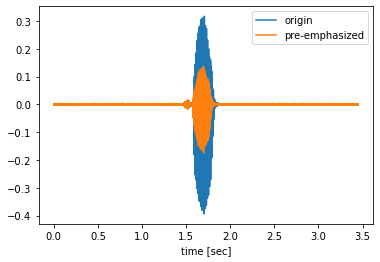

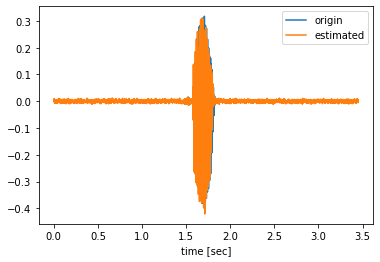

In [3]:
Fs=16000

L_random=int(Fs)
Ns=int(Fs*0.01)

filename="./kdigits1-3.wav"
# filename="./lab04_car.wav"
# filename="./kdigits_custom/InkooJeon/0/kdigits0-0.wav"

x,fs=librosa.load(filename)
# x=x[int(Fs):int(Fs*2.5)]

vc=vocoder_LSF(alpha=0.95,eps=1e-3)

H_test=FIR(M=14)


X_hat=[]
E=[]
X_p=[]
X_pn=[]
X_pn_hat=[]

max_iter=int((len(x)+Ns-1)//Ns)
for idx in range(max_iter):
    if idx >=len(x)//Ns:
        x_tmp=x[(idx)*Ns:]
        x_i=np.concatenate([x_tmp,np.zeros(Ns-len(x_tmp))])
    else:
        x_i=x[(idx)*Ns:(idx+1)*Ns]
    
    x_p,x_pn,e,a=vc.Encoding_with_LSF(x_i)
#     print(len(a))
    x_pn_hat,x_hat=vc.Decoding_with_LSF(e,a)

    E.append(e)
    X_hat.append(x_hat)
    X_p.append(x_p)
    X_pn.append(x_pn)
    X_pn_hat.append(x_pn_hat)
        
    
#     print(f"[{idx}th] done!")
    
    
X_hat=np.concatenate(X_hat)
E=np.concatenate(E)
X_p=np.concatenate(X_p)
X_pn=np.concatenate(X_pn)
X_pn_hat=np.concatenate(X_pn_hat)


import matplotlib.pyplot as plt

time=np.arange(len(X_hat))/Fs

plt.figure()

plt.plot(time[-len(x):],x)
plt.plot(time,X_pn)
plt.xlabel("time [sec]")
plt.legend(['origin','pre-emphasized'])
# plt.plot(time,E)
# plt.plot(time,X_p)

err=vc.Evaluate(x,X_hat) # 아마 phase가 달라서 error 값이 큰 것 같다.

plt.figure() # plot상에서는 거의 똑같이 복원 가능한 것으로 보인다.
plt.plot(time[-len(x):],x)
plt.plot(time,X_hat)
plt.legend(['origin','estimated'])
plt.xlabel("time [sec]")
# plt.plot(time,E)
# plt.plot(time,X_pn_hat)
# plt.plot(time,err)



---
### Pitch
#####     Voiced signal은 성대가 만들어내는 pulse가 기도, 구강, 비강등을 지나면서 만들어진다.
#####     그 pulse의 주기를 pitch로 정의하고, 
#####     음성신호의 auto correlation 값의 극댓값으로 추정할 수 있다.

##### cf.) Voiced signal이 지나는 경로는 LPC를 통해 FIR 필터로 모델링된다.
---
### Gaussian random variables
#####     Unvoiced signal은 파열, 마찰음 등의 노이즈 성분이 크다.
#####     해당 부류의 소리는 Gaussian random variable로 모델링할 수 있다.
---
#### 즉, Vocoder에서 Voiced / Unvoiced를 판단할 수 있다면,
#### Exitation을 저장하지 않아도, 모델링들로 Exitation을 추정할 수 있다.

In [4]:
#################################################################

# Exitation generation module

#################################################################
from scipy.signal import find_peaks

class exitat_gen:
    def __init__(self,Ns,Fs=16000):
        self.pitch=np.ones(7)*(-1)
        self.sign=1
        self.start_point=0
        self.Fs=Fs
        self.Ns=Ns
        
    def pitch_estimate(self,x): 
        # Auto Correlation caculation to chose pitch
        ac=[]
        for tau in range(self.Ns):
            L=self.Ns-tau
            ac_tmp=np.sum(x[tau:]*x[:L])
            ac.append(ac_tmp)
        ac=np.array(ac)
        peaks, _ = find_peaks(x, height=0)
        if peaks[1]<2:
            peaks=peaks[1:]
        peak_pos=peaks[np.argmax(ac[peaks])]
        
        pitch_tmp=self.pitch[0]
        
        pitch=self.Fs/peak_pos
        
        if pitch_tmp==-1:
            self.pitch=self.pitch*(-1)*pitch
        else:
            self.pitch[1:]=self.pitch[:-1]
            self.pitch[0]=pitch

        return np.median(self.pitch) # median filtering
    
    def glotto_pulse(self,pitch): 
        # pulse generation for Voiced sound
        output=np.zeros(self.Ns)
        tau=self.Fs/pitch
        idx=0+self.start_point
        while True:
            output[idx]=self.sign
            idx=int(idx+tau/2)
            if(idx>=self.Ns):
                self.sign=self.sign*(-1)
                break
            output[idx]=self.sign*(-1)
            idx=idx+int(tau-tau/2)
            if(idx>=self.Ns):
                self.sign=self.sign
                break
        
        self.start_point=idx-self.Ns
        return output
    
    def Gaussian_rand(self): 
        # Gaussian noise generation for Unvoiced sound
        output=normal(0,1,self.Ns)
        return output
    
    def VUV_decision(self,x):
        # Decision for Voiced/ Unvoiced
        Nx=len(x)
        Ns=self.Ns
        th=0.5
        result=np.zeros(Nx)
        for idx in range(Nx//Ns): # Ns 단위로 auto correlation의 값을 추정
            x_i=x[idx*Ns:(idx+1)*Ns]
            r0=np.mean(x_i*x_i)
            r1=np.mean(x_i[1:]*x_i[:-1])
            result[idx*Ns:(idx+1)*Ns]=(r1/r0)>th +0
        x_i=x[idx*Ns:]
        r0=np.mean(x_i*x_i)
        r1=np.mean(x_i[1:]*x_i[:-1])
        result[idx*Ns:]=(r1/r0)>th +0 
        
        output=(np.mean(result)>=th)+0
        EPD = (np.mean(x**2)>1e-4)+0 # EPD for precise decision
        return output*EPD # voiced면 1 아니면 0
    
    def VUV_exit_gen(self,x,E_residual):
        # make exitation with Voiced/ Unvoiced decision
        flag_VUV=self.VUV_decision(x)
        if flag_VUV: # Voiced
            output=self.glotto_pulse(x)
        else: # Unvoiced
            output=self.Gaussian_rand()

        E_exi=np.sqrt(np.mean(np.sum(output**2)))
        output=output*E_residual/E_exi
        return output


In [5]:
class vocoder_Exi(vocoder_LSF): # Vocoder with Exitation generation
    def __init__(self,M=14,alpha=0.95,Fs=16000,eps=1e-6):
        super().__init__(M,alpha,Fs,eps)
        self.Exi=exitat_gen(self.Ns,Fs)
        
    def Encoding_Exi(self,x): 
        # time signal -> (Voiced/Unvoiced, pitch, LFC,E_residual)
        flag_SV=(np.mean(x**2)>1e-6)+0
        flag_VUV=-1
        pitch=-1
        E_residual=-1
        if flag_SV==1: # if signal isn't silence
            flag_VUV=self.Exi.VUV_decision(x) # decide for Voiced /Unvoiced
        x_p,x_pn,e,L=self.Encoding_with_LSF(x) # encoding
        E_residual=np.mean(e**2)
        if flag_VUV==1: # if signal is Voiced siganl
            pitch=self.Exi.pitch_estimate(x)
        
        return flag_VUV,pitch,L,E_residual,e
    
    def Decoding_Exi(self,flag_VUV,pitch,L,E_residual):
        #  (Voiced/Unvoiced, pitch, LFC,E_residual) -> time signal
        
        if flag_VUV==1: # Voiced signal
            e=self.Exi.glotto_pulse(pitch)
            e=e*np.sqrt(E_residual/np.mean(e**2))
        elif flag_VUV==0: # Unvoiced signal
            e=self.Exi.Gaussian_rand()*np.sqrt(E_residual)
        else:
            e=np.zeros(self.Ns)
        # Exitation in here is generated by pitch pulse
        _,x_hat=self.Decoding_with_LSF(e,L) # Decoding
        return e,x_hat

Text(0.5, 1.0, 'exitation_generated')

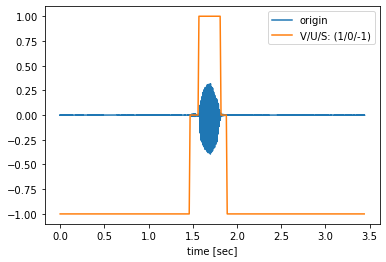

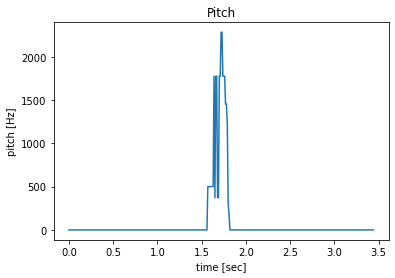

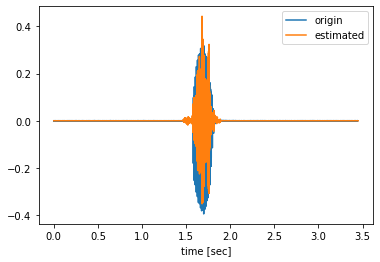

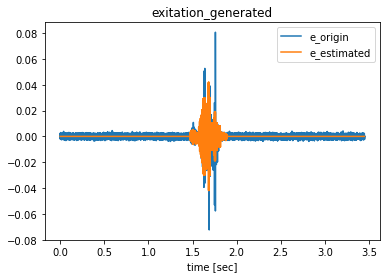

In [6]:
Fs=16000

L_random=int(Fs)
Ns=int(Fs*0.01)

filename="./kdigits1-3.wav"

x,fs=librosa.load(filename)
vc=vocoder_Exi(alpha=0.95,eps=1e-3)

X_hat=[]
flag_VUV_table=[]
pitch_table=[]
e_hat_table=[]
e_table=[]
max_iter=int((len(x)+Ns-1)//Ns)
for idx in range(max_iter):
    if idx >=len(x)//Ns:
        x_tmp=x[(idx)*Ns:]
        x_i=np.concatenate([x_tmp,np.zeros(Ns-len(x_tmp))])
    else:
        x_i=x[(idx)*Ns:(idx+1)*Ns]
    
    flag_VUV,pitch,L,E_residual,e = vc.Encoding_Exi(x_i)
    e_hat,x_hat=vc.Decoding_Exi(flag_VUV,pitch,L,E_residual)

    X_hat.append(x_hat)
#     print(x_hat.shape)
    flag_VUV_table.append(flag_VUV)
    pitch_table.append(pitch)
    e_hat_table.append(e_hat)
    e_table.append(e)
    
X_hat=np.concatenate(X_hat)
flag_VUV_table=np.array(flag_VUV_table)
pitch_table=np.array(pitch_table)
e_hat_table=np.concatenate(e_hat_table)
e_table=np.concatenate(e_table)
# E=np.concatenate(E)
# X_p=np.concatenate(X_p)
# X_pn=np.concatenate(X_pn)
# X_pn_hat=np.concatenate(X_pn_hat)


import matplotlib.pyplot as plt

time=np.arange(len(x))/Fs

# 원본신호의 Voiced / Unvoiced를 잘 구분해내는 것을 확인할 수 있다.
plt.figure() 
plt.plot(time[-len(x):],x)
plt.plot(np.arange(len(flag_VUV_table))*0.01,flag_VUV_table)
plt.xlabel("time [sec]")
plt.legend(['origin','V/U/S: (1/0/-1)'])
# V: Voiced, U : Unvoiced, S : Silence

# pitch가 시간에 따라 어떻게 변하는지를 확인할 수 있다.
plt.figure()
plt.plot(np.arange(len(pitch_table))*0.01,pitch_table)
plt.xlabel("time [sec]")
plt.ylabel("pitch [Hz]")
plt.title("Pitch")

# 원본신호와 복원된 신호의 차이를 보여주고 있다.
plt.figure()
plt.plot(time[-len(x):],x)
plt.plot(np.arange(len(X_hat))/Fs,X_hat)
plt.xlabel("time [sec]")
plt.legend(['origin','estimated'])


# 복원된 신호와 원본신호의 차이가 큰 것에 비해서,
# Exitation은 거의 유사하게 추정했음을 확인할 수 있다.
plt.figure()
plt.plot(np.arange(len(e_table))/Fs,e_table)
plt.plot(np.arange(len(e_hat_table))/Fs,e_hat_table)
plt.xlabel("time [sec]")
plt.legend(['e_origin','e_estimated'])
plt.title("exitation_generated")
